# 882 Replication Paper: Flabbi 2010

- Read in data
- Define log-normal pdf & cdf 
- Estimate men and women separately to allow for parameters to very by gender

## Import Packages

In [1]:
# Data Manipulation 
import numpy as np
import pandas as pd

# General
import pdb

# Estimation
from scipy.optimize import minimize
import scipy.stats as stats
# import numdifftools as ndt

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn.apionly as sns
from pylab import *

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Import Data 

- CPS data on gender, wages, duration of unemployment
- M: males
- F: females
- U: unemployed
- E: employed 
- {M,F} X {E,U} = {males,females} X {employed, unemployed}

In [2]:
data=pd.read_csv('../data/est_c.csv')
data.columns = ['dur', 'wage', 'empl', 'women']

M = data[data['women']==0] #1186 men 
F = data[data['women']==1] #993 women 
U = data[data['empl']==0] #45 unemployed
E = data[data['empl']==1] #2134 employed

ME = M[M['empl']==1] #1109 employed men
MU = M[M['empl']==0] #18 unemployed men
FE = F[F['empl']==1] #966 employed women
FU = F[F['empl']==0] #27 unemployed women

In [3]:
data.describe()

,dur,wage,empl,women
count,2179.000000,2179.000000,2179.000000,2179.000000
mean,0.088220,18.756224,0.979348,0.455714
std,0.824531,9.781042,0.142248,0.498149
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,1.000000,0.000000
50%,0.000000,17.440000,1.000000,0.000000
75%,0.000000,24.038750,1.000000,1.000000
max,15.000000,65.000000,1.000000,1.000000


### Summary Statistics, without trimming

In [4]:
agg_dict = {
    'wage': ['mean', 'std'],
    'dur': ['mean', 'std'],
}

In [5]:
print(data.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrr}
\toprule
  &   & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
  &   &       mean &       std &      mean &       std \\
women & empl &            &           &           &           \\
\midrule
0 & 0 &   0.000000 &  0.000000 &  4.923077 &  4.687447 \\
  & 1 &  21.258393 &  9.890162 &  0.000000 &  0.000000 \\
1 & 0 &   0.000000 &  0.000000 &  3.837607 &  3.341191 \\
  & 1 &  16.604563 &  8.307586 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



In [6]:
print(data.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
{} &       mean &       std &      mean &       std \\
empl &            &           &           &           \\
\midrule
0    &   0.000000 &  0.000000 &  4.271795 &  3.921109 \\
1    &  19.151739 &  9.492563 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



### Summary Statistics, with trimming

In [6]:
print(np.percentile(ME['wage'], 5))

7.2700000000000005


In [7]:
print(np.percentile(FE['wage'], 5))

5.75625


In [35]:
M_WAGE_COND = (data['wage'] > 7.27) #hard coded percentile so it does not continually update
M_COND = (data['women'] == 0)

F_WAGE_COND = (data['wage'] > 5.75625) #hard coded percentile so it does not continually update
F_COND = (data['women'] == 1)

DUR_COND = (data['dur'] > 0)

trim = data[ (M_COND & M_WAGE_COND) | (F_COND & F_WAGE_COND) | DUR_COND ]

# trim = data[ (M_COND & (M_WAGE_COND | DUR_COND)) | (F_COND & (F_WAGE_COND | DUR_COND)) ]

M = trim[trim['women']==0] #1071 ?? men 
F = trim[trim['women']==1] #944 ?? women 
U = trim[trim['empl']==0] #45 unemployed
E = trim[trim['empl']==1] #1970 ?? employed

ME = M[M['empl']==1] #1053 ?? employed men
MU = M[M['empl']==0] #18 unemployed men
FE = F[F['empl']==1] #917 employed women
FU = F[F['empl']==0] #27 unemployed women

In [40]:
FE.describe()

,dur,wage,empl,women
count,917.0,917.000000,917.0,917.0
mean,0.0,17.263817,1.0,1.0
std,0.0,8.002224,0.0,0.0
min,0.0,5.775000,1.0,1.0
25%,0.0,11.769230,1.0,1.0
50%,0.0,15.911110,1.0,1.0
75%,0.0,21.000000,1.0,1.0
max,0.0,64.100000,1.0,1.0


In [37]:
print(trim.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrr}
\toprule
  &   & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
  &   &       mean &       std &      mean &       std \\
women & empl &            &           &           &           \\
\midrule
0 & 0 &   0.000000 &  0.000000 &  4.923077 &  4.687447 \\
  & 1 &  22.093013 &  9.440473 &  0.000000 &  0.000000 \\
1 & 0 &   0.000000 &  0.000000 &  3.837607 &  3.341191 \\
  & 1 &  17.263817 &  8.002224 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



In [38]:
print(trim.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
{} &       mean &       std &      mean &       std \\
empl &            &           &           &           \\
\midrule
0    &   0.000000 &  0.000000 &  4.271795 &  3.921109 \\
1    &  19.907242 &  9.138453 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



## Figures 

- Distribution of wages, men and women

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


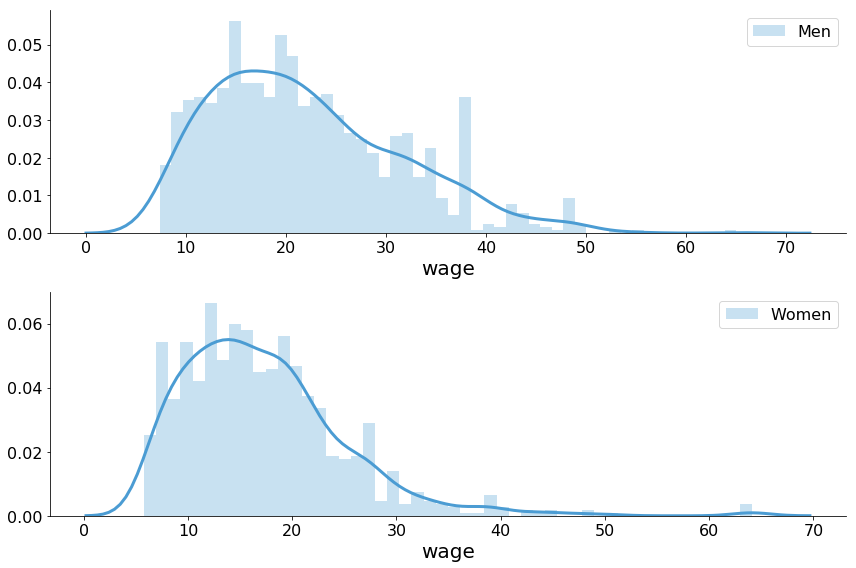

In [41]:
# Seaborn
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.distplot(ME['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[0])
sns.distplot(FE['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[1])

ax[0].legend(['Men'])
ax[1].legend(['Women']) 

plt.tight_layout()

In [13]:
fig.savefig('./figures/fig1_2.png', bbox_inches='tight', transparent=True)

## Estimation 

- Estimations 1-3: Same arrival and termination rates
- Estimations 4-6: Gender specific arrival and termination rates

In [42]:
# Initial Conditions

wstarM = min(ME['wage'])
wstarF = min(FE['wage'])

λ_M = 0.22
λ_F = 0.22
η_M = 0.005
η_F = 0.005
# α = 0.5  #FIXED
μ_M = 3.456
μ_F= 3.454
σ_M = 0.558
σ_F = 0.423
p = 0.5
d_F = 10
# d_M = 0   #FIXED

### Wage Function

In [43]:
def f_w(wage: np.array, α: float, wstar: float):
    """
    Wage functions
    """
    return (wage - (1-α)*wstar)*(1/α)

### Estimation 1: Same arrival and termination, Productivity Differences, No Prejudice

In [44]:
def loglik1(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ = np.exp(params[0])
    η = np.exp(params[1])
    μ_M = params[2]
    σ_M = np.exp(params[3])
    μ_F = params[4]
    σ_F = np.exp(params[5])
    d_F = 0
    p = 0
    α = 0.5

    
    hM = λ * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η/(η+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η+hM)) + np.sum( np.log(L01a) ); #employed men
    
    hF = λ*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η/(η+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η+hF)) + np.sum( np.log(L11a + L11b) ); #employed women

    results = np.log(L00) + L01 + np.log(L10) + L11

    return -1*results

In [51]:
init1 = [λ_M, η_M, μ_M, σ_M, μ_F, σ_F]

est1 = minimize(loglik1, init1, method='nelder-mead', options={'maxiter': 10000})

In [48]:
# est1 default

print(est1.x)
print(-loglik1(est1.x))

[ -3.01297622  -4.57125719   2.37653876 -13.63984137   2.28903797
 -15.75794221]
-7949.470226031752


In [52]:
# est1 nelder

print(est1.x)
print(-loglik1(est1.x))

[-3.01291264e+00 -4.57096806e+00  2.37653919e+00 -1.69191267e+02
  2.28903646e+00 -2.33688224e+04]
-7949.470192520894


#### Test Statistics

In [53]:
# Standard Errors

vcv_mle1 = est1.hess_inv
se1 = np.sqrt(np.diag(vcv_mle1))
print('Standard errors are given in ', se1)

# Likelihood Ratio Test

LR_val_1 = 2 * (-loglik1(est1.x) + loglik1(init1))
pval_h0_1 = 1.0 - stats.chi2.cdf(LR_val_1, 5)
print('LR value = ', LR_val_1, '. Chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0_1)

AttributeError: hess_inv

### Estimation 2: Same arrival and termination, Prejudice, No Productivity Differences

In [54]:
def loglik2(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
  
    λ = np.exp(params[0])
    η = np.exp(params[1])
    μ = params[2]
    σ = np.exp(params[3])
    d_F = np.exp(params[5])
    p = np.exp(params[4]) / (1 + np.exp(params[4]))
    α = 0.5

#    pdb.set_trace()
    
    hM = λ * ( (1-stats.lognorm.cdf(wstarM,μ,σ)) );
    L00 = (η/(η+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ,σ) )/(1-stats.lognorm.cdf(wstarM,μ,σ)) );
    L01 = np.log(hM/(η+hM)) + np.sum( np.log(1+L01a) ); #employed men
    
    hF = λ * ( (1-p)*(1-stats.lognorm.cdf(wstarF,μ,σ)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ,σ)) );
    L10 = ( (η/(η+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ,σ) ) / (1-stats.lognorm.cdf(wstarF,μ,σ)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+ α*d_F),α,wstarF),μ,σ) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ,σ)) );
    L11 = np.log(hF/(η+hF)) + np.sum( np.log(1+L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [55]:
init2 = [λ_M, η_M, μ_M, σ_M, p, d_F]

est2 = minimize(loglik2, init2, method='nelder-mead', options={'maxiter': 10000})

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [17]:
# est2

print(est2.x)
print(-loglik2(est2.x))

[60.75192287 -2.35414311  1.7254563   1.34035391 32.90797981  3.43498699]
30.4223264958016


#### Test Statistics

In [148]:
# Standard Errors

vcv_mle2 = est2.hess_inv
se2 = np.sqrt(np.diag(vcv_mle2))
print('Standard errors are given in ', se2)

# Likelihood Ratio Test

LR_val_2 = 2 * (-loglik2(est2.x) + loglik2(init2))
pval_h0_2 = 1.0 - stats.chi2.cdf(LR_val_2, 5)
print('LR value = ', LR_val_2, '. Chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0_2)


Standard errors are given in  [ 9.07773691 39.75381239  0.04203081 19.94898012 34.71304461  0.1468559 ]
LR value =  1852.5488819398852 . Chi squared of H0 with 5 degrees of freedom p-value =  0.0


### Estimation 3: Same arrival and termination, Productivity Differences and Prejudice

In [152]:
def loglik3(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ = np.exp(params[0])
    η = np.exp(params[1])
    μ_M = params[2]
    σ_M = np.exp(params[3])
    μ_F = params[4]
    σ_F = np.exp(params[5])
    d_F = np.exp(params[7])
    p = (np.exp(params[6]))/(1+np.exp(params[6]))
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η/(η+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η+hM)) + np.sum( np.log(L01a) ); #employed men
    
    hF = λ * ( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η/(η+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η+hF)) + np.sum( np.log(L11a + L11b) ); #employed women

    results = np.log(L00) + L01 + np.log(L10) + L11

    return -1*results

In [153]:
init3 = [λ_M, η_M, μ_M, σ_M, μ_F, σ_F, p, d_F]

est3 = minimize(loglik3, init3, options={'maxiter': 10000})

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [154]:
print(est3.x)
print(-loglik3(est3.x))

[ -378.70387036   -16.63649903  -877.48975899  -699.21727712
 -2686.22637477  -489.47837348   882.44674051  -824.72286138]
nan


/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


#### Test Statistics

In [27]:
# Standard Errors

vcv_mle3 = est3.hess_inv
se3 = np.sqrt(np.diag(vcv_mle3))
print('Standard errors are given in ', se3)

# Likelihood Ratio Test

LR_val_3 = 2 * (-loglik3(est3.x) + loglik3(init3))
pval_h0_3 = 1.0 - stats.chi2.cdf(LR_val_3, 5)
print('LR value = ', LR_val_3, '. Chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0_3)


Standard errors are given in  [0.99942382 1.00002089 0.55859911 1.01919404 0.95774826 0.99854331
 0.99832652 1.        ]
LR value =  nan . Chi squared of H0 with 5 degrees of freedom p-value =  nan


### Estimation 4: Productivity Differences, No Prejudice

In [18]:
def loglik4(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[1])
    η_M = np.exp(params[2])
    η_F = np.exp(params[3])
    μ_M = params[4]
    σ_M = np.exp(params[5])
    μ_F = params[6]
    σ_F = np.exp(params[7])
    d_F = 0
    p = 0
    α = 0.5
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(L11a + L11b) ); #employed women

    results = np.log(L00) + L01 + np.log(L10) + L11

    return -1*results

In [19]:
init4 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F]

est4 = minimize(loglik4, init4, method='nelder-mead', options={'maxiter': 10000})

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [20]:
print(est4.x)
print(-loglik4(est4.x))

[0.22  0.22  0.005 0.005 3.456 0.558 3.454 0.423]
-inf


/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


#### Test Statistics

In [158]:
# Standard Errors

vcv_mle4 = est4.hess_inv
se4 = np.sqrt(np.diag(vcv_mle4))
print('Standard errors are given in ', se4)

# Likelihood Ratio Test

LR_val_4 = 2 * (-loglik4(est4.x) + loglik4(init4))
pval_h0_4 = 1.0 - stats.chi2.cdf(LR_val_4, 7)
print('LR value = ', LR_val_4, '. Chi squared of H0 with 7 degrees of freedom p-value = ', pval_h0_4)


Standard errors are given in  [9.21564686e-01 8.63670863e-01 1.52208582e+00 1.58640875e+00
 4.38297886e-02 1.32540316e+02 4.34545802e-02 1.11311020e+02]
LR value =  776.7044136924596 . Chi squared of H0 with 7 degrees of freedom p-value =  0.0


### Estimation 5: Prejudice, No Productivity Differences

In [159]:
def loglik5(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[1])
    η_M = np.exp(params[2])
    η_F = np.exp(params[3])
    μ = params[4]
    σ = np.exp(params[5])
    d_F = np.exp(params[7])
    p = (np.exp(params[6]))/(1+np.exp(params[6]))
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ,σ)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ,σ) )/(1-stats.lognorm.cdf(wstarM,μ,σ)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(1 + L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ,σ)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ,σ)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ,σ) ) / (1-stats.lognorm.cdf(wstarF,μ,σ)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ,σ) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ,σ)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(1 + L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [160]:
init5 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, p, d_F]

est5 = minimize(loglik5, init5, method='nelder-mead', options={'maxiter': 10000})

In [161]:
est5.x

array([  123.13924458,    42.45822219,     9.84169944,     8.31474923,
           1.60354081, -1199.95077476, -1240.3386432 ,   -76.15708422])

### Estimation 6: Productivity Differences and Prejudice

In [162]:
def loglik6(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[1])
    η_M = np.exp(params[2])
    η_F = np.exp(params[3])
    μ_M = params[4]
    σ_M = np.exp(params[5])
    μ_F = params[6]
    σ_F = np.exp(params[7])
    d_F = np.exp(params[9])
    p = (np.exp(params[8]))/(1+np.exp(params[8]))
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(1 + L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(1 + L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [167]:
init6 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F, p, d_F]

est6 = minimize(loglik6, init6)#options={'maxiter': 10000})

In [168]:
est6.x

array([  858.35840014,   876.79671601,  -858.13340014,  -876.57171601,
       -1047.68182271,  -121.78802029, -5568.08713766,   450.43856927,
       -4202.11715697, -2500.71399205])

In [37]:
pd.DataFrame(est1.x,est2.x,est3.x,est4.x,est5.x,est6.x)

TypeError: __init__() takes from 1 to 6 positional arguments but 7 were given

## Scratch

### Parameters without distributional assumptions

In [75]:
wstarM = min(ME['wage'])
wstarF = min(FE['wage'])

hM = MU['dur'].count()/sum(MU.values[:,0])
hF = FU['dur'].count()/sum(FU.values[:,0])
h = U['dur'].count()/sum(U.values[:,0])

ηM = hM * (MU['dur'].count()/ME['empl'].count())
ηF = hF * (FU['dur'].count()/FE['empl'].count())
η = h * (U['dur'].count()/E['empl'].count())

### Accepted Wages

In [43]:
def f_w(wage: np.array, α: float, wstar: float):
    """
    Wage functions
    """
    return (wage - (1-α)*wstar)*(1/α)

In [92]:
def dens_accepted(wage: np.array, α: float, μ: float, σ: float, wstar: float):
    """
    Calculates the density of accepted wages
    """
    
    l = (α*μ) + ((1-α)*wstar)
    s = α * σ
    shape = .5
    
    return stats.lognorm.pdf(wage,shape,l,s) / stats.lognorm.sf(wstar, shape, l, s)

In [95]:
def dens_accepted_prej(wage: np.array, α: float, μ: float, σ: float, wstar: float, d: float):
    """
    Calculates the density of accepted wages for men
    """
    
    l = (α*μ) + ((1-α)*wstar) - αd
    s = α * σ
    shape = .5
    
    return stats.lognorm.pdf(wage,shape,l,s) / stats.lognorm.sf(wstar, shape, l, s)

In [96]:
def lambdaM(h: float, wstarM: float, α: float, μ: float, σ: float):
    """
    Estimates lambda for men
    """
    
    l = (α*μ) + ((1-α)*wstar)
    s = α * σ
    shape = .5
    
    denom = stats.lognorm.sf(wstarM,shape, l, s)
    
    return h/denom

In [ ]:
def lambdaF(h: float, p: float, wstarF: float, α: float, μ: float, σ: float):
    """
    Estimates lambda for women
    """
    
    l1 = (α*μ) + ((1-α)*wstar)
    l2 = (α*μ) + ((1-α)*wstar) - αd
    s = α * σ
    shape = .5
    
    denom = (1-p)*stats.lognorm.sf(wstar, shape, l1, s) + p*stats.lognorm.sf(wstar, shape, l2, s)
    
    return h/denom

### Likelihood Functions

In [ ]:
def loglik_6( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences 
    
    Estimation 6 (ηM, ηF, hM, hF)
    
    Parameters to estimate: 
    λM # see fxn elsewhere
    λF # see fxn elsewhere
    μM
    σM
    μF
    σF
    d
    p
    """
    
    # Men's equations 
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    d = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    e = F['dur'].count() * np.log(hF/(hF+ηF))
    f = FU['dur'].count * np.log(ηF)
    g = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μF, σF, wstarF, d)

    h = np.sum( np.log( y + z ) )
    
    
    return a + b + c + d + e + f + g + h

In [ ]:
def loglik_3( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences 
    
    Estimation 3 (η and h not gender specific)
    
    Parameters to estimate: 
    λ # see fxn elsewhere
    μM
    σM
    μF
    σF
    d
    p
    """

    
    # Men's equations 
    a = M['dur'].count() * np.log(h/(h+η))
    b = MU['dur'].count() * np.log(η)
    c = - h * np.sum(MU.values[:,0])
    d = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    e = F['dur'].count() * np.log(h/(h+η))
    f = FU['dur'].count * np.log(η)
    g = - h * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μF, σF, wstarF, d)

    h = np.sum( np.log( y + z ) )
    
    
    return a + b + c + d + e + f + g + h

In [ ]:
def loglik_5( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences. 
    
    Estimation 5 (ηM, ηF, hM, hF)
    
    Parameters to estimate: 
    λM # see fxn elsewhere
    λF # see fxn elsewhere
    μ
    σ
    p
    d
    """

    
    # Men's equations 
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    d = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    e = F['dur'].count() * np.log(hF/(hF+ηF))
    f = FU['dur'].count * np.log(ηF)
    g = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    h = np.sum( np.log( y + z ) )
    
    
    return a + b + c + d + e + f + g + h

In [ ]:
def loglik_2( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences. 
    
    Estimation 2 (η and h not gender specific)
    
    Parameters to estimate: 
    λ # see fxn elsewhere
    μ
    σ
    p
    d
    """

    
    # Men's equations 
    a = M['dur'].count() * np.log(h/(h+η))
    b = MU['dur'].count() * np.log(η)
    c = - h * np.sum(MU.values[:,0])
    d = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    e = F['dur'].count() * np.log(h/(h+η))
    f = FU['dur'].count * np.log(η)
    g = - h * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    h = np.sum( np.log( y + z ) )
    
    
    return a + b + c + d + e + f + g + h

In [ ]:
def loglik_4( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice
    
    Estimation 4 (ηM, ηF, hM, hF)
    
    Parameters to estimate: 
    λM # see fxn elsewhere
    λF # see fxn elsewhere
    μM
    σM
    μF
    σF
    """

    
    # Men's equations 
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    d = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    e = F['dur'].count() * np.log(hF/(hF+ηF))
    f = FU['dur'].count * np.log(ηF)
    g = - hF * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)

    h = np.sum( np.log( y ) )
    
    
    return a + b + c + d + e + f + g + h

In [ ]:
def loglik_1( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice
    
    Estimation 1 (η and h not gender specific)
    
    Parameters to estimate: 
    λ
    μM
    σM
    μF
    σF
    """

    
    # Men's equations 
    a = M['dur'].count() * np.log(h/(h+η))
    b = MU['dur'].count() * np.log(η)
    c = - h * np.sum(MU.values[:,0])
    d = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    e = F['dur'].count() * np.log(h/(h+η))
    f = FU['dur'].count * np.log(η)
    g = - h * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)

    h = np.sum( np.log( y ) )
    
    
    return a + b + c + d + e + f + g + h